## Object

* Use predicted booking probability from booking probability model as input to build Pricing strategy model
* Pricing strategy model: predict the rent price for each vehicle as recommendation price

In [1]:
import numpy as np 
import math 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import os 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
import pickle as pk
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pandas.plotting import scatter_matrix
import eli5
from eli5.sklearn import PermutationImportance
### Own module
import Common_Includes as CI
import Feature_Selection as FS
import WOE as woe
import Model_Evaluation as ME
random_seed = 201976

In [2]:
ME.cross_verify_regerssion

<function Model_Evaluation.cross_verify_regerssion(x, y, estimators, fold, scoring='neg_mean_squared_error')>

## Load Dataset

In [3]:
def load_data(filename):
    print('Data File Name: {}'.format(filename))
    dataset = pd.read_csv(filename)
    return dataset

In [ ]:
dataframe = load_data(r'dataframe_price_booking_probability.csv')

In [5]:
CI.summarize_dataset(dataframe, 'is_booked')

(1890, 20)
   vehicle_id        date    tmv category_grouped  demand_supply_ratio  price  \
0      497131  2018-11-30   3875          compact             8.348333     25   
1      174075  2018-08-26   5669          midsize            12.210682     46   
2      289235  2018-07-06  17755          midsize             1.959080     55   
3      456223  2019-02-06   9666          midsize             0.741782     52   
4      300476  2018-04-09   6353              suv             5.295696     27   

  year_month  day_of_month  day_of_week  weekend  holiday  \
0    2018-11            30            5        0        0   
1    2018-08            26            7        1        0   
2    2018-07             6            5        0        0   
3    2019-02             6            3        0        0   
4    2018-04             9            1        0        0   

   category_grouped_num  most_recent_booked_price  most_recent_nobooked_price  \
0                     0                      25.0     

In [6]:
CI.describe_table(dataframe)

,Variable Name,Variable Type,Unique Values,Percentage of Missing Value
0,index,int64,1890,0.00%
1,holiday,int64,2,0.00%
2,select,object,2,0.00%
3,is_booked,int64,2,0.00%
4,average_list_price_past28days,float64,737,0.00%
5,booked_rate_past28days,float64,64,0.00%
6,days_past_since_last_booked,float64,191,0.00%
7,most_recent_nobooked_price,float64,73,0.00%
8,most_recent_booked_price,float64,66,0.00%
9,category_grouped_num,int64,5,0.00%


In [7]:
dataframe.columns

Index(['vehicle_id', 'date', 'tmv', 'category_grouped', 'demand_supply_ratio',
       'price', 'year_month', 'day_of_month', 'day_of_week', 'weekend',
       'holiday', 'category_grouped_num', 'most_recent_booked_price',
       'most_recent_nobooked_price', 'days_past_since_last_booked',
       'booked_rate_past28days', 'average_list_price_past28days', 'is_booked',
       'select', 'probability_booked'],
      dtype='object')

In [8]:
col = ['tmv', 'demand_supply_ratio',
       'price', 'day_of_month', 'day_of_week', 'weekend',
       'holiday', 'category_grouped_num', 'most_recent_booked_price',
       'most_recent_nobooked_price', 'days_past_since_last_booked',
       'booked_rate_past28days', 'average_list_price_past28days',
       'probability_booked']

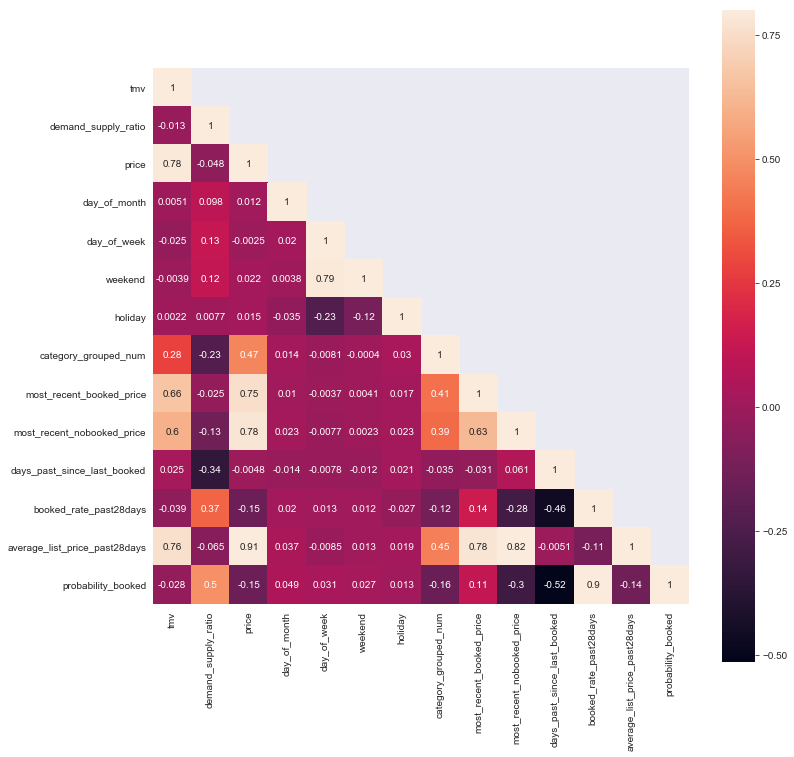

In [9]:
plt.figure(figsize=(12,12))
mask = np.array(dataframe[col].corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(dataframe[col].corr(), mask=mask,
           vmax=.8, square=True,annot=True)

## Model Data Preparation

In [10]:
dataframe.drop('select', axis = 1, inplace = True)

In [11]:
# Divide the dataset 
def split_data(data, cols_X, cols_Y, seed = random_seed, size = 0.3):
    df = data.copy()
    df = df.sample(frac = 1, random_state = seed)
    train_X, test_X, train_Y, test_Y = train_test_split(
                                            df.loc[:, cols_X], 
                                            df.loc[:, cols_Y], 
                                            test_size=size,
                                            random_state = seed
                                            )
    train = train_X.merge(pd.DataFrame(train_Y), left_index = True, right_index = True, how = 'inner')
    train['select'] = 'Development'
    test = test_X.merge(pd.DataFrame(test_Y), left_index = True, right_index = True, how = 'inner')
    test['select'] = 'Test'
    df1 = pd.concat([train, test])
    return df1

#### Split dataset into Development dataset (70%) and test (30%) 
* Development dataset will use for the model training and cross validation for hyperparameter tuning
* Test dataset will use for the model performance evaluation

In [12]:
var_list = ['vehicle_id', 'date', 'tmv', 'category_grouped', 'demand_supply_ratio',
       'year_month', 'day_of_month', 'day_of_week', 'weekend',
       'holiday', 'category_grouped_num', 'most_recent_booked_price',
       'most_recent_nobooked_price', 'days_past_since_last_booked',
       'booked_rate_past28days', 'average_list_price_past28days', 'is_booked',
       'select', 'probability_booked']

In [13]:
dataframe1 = split_data(dataframe, var_list, 'price')

In [14]:
dataframe1.head()

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,year_month,day_of_month,day_of_week,weekend,holiday,category_grouped_num,most_recent_booked_price,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select,probability_booked,price
758,508104,2018-10-21,5148,suv,8.616425,2018-10,21,7,1,0,2,39.0,44.0,21.0,0.200000,43.00,0,Development,0.174835,44
101,326416,2018-12-10,12762,suv,3.059283,2018-12,10,1,0,0,2,40.0,40.0,27.0,0.071429,40.00,0,Development,0.089107,40
270,298081,2019-01-07,5724,midsize,7.097282,2019-01,7,1,0,0,1,26.0,26.0,5.0,0.875000,25.75,1,Development,0.871653,26
110,174075,2018-05-01,5669,midsize,4.617152,2018-05,1,2,0,0,1,30.0,30.0,8.0,0.666667,30.00,1,Development,0.685656,34
353,426430,2019-01-29,7115,midsize,3.574344,2019-01,29,2,0,0,1,46.0,46.0,11.0,0.666667,41.00,0,Development,0.356414,46


In [15]:
CI.summarize_dataset(dataframe1[dataframe1['select'] == 'Development'], 'is_booked')

(1323, 20)
     vehicle_id        date    tmv category_grouped  demand_supply_ratio  \
758      508104  2018-10-21   5148              suv             8.616425   
101      326416  2018-12-10  12762              suv             3.059283   
270      298081  2019-01-07   5724          midsize             7.097282   
110      174075  2018-05-01   5669          midsize             4.617152   
353      426430  2019-01-29   7115          midsize             3.574344   

    year_month  day_of_month  day_of_week  weekend  holiday  \
758    2018-10            21            7        1        0   
101    2018-12            10            1        0        0   
270    2019-01             7            1        0        0   
110    2018-05             1            2        0        0   
353    2019-01            29            2        0        0   

     category_grouped_num  most_recent_booked_price  \
758                     2                      39.0   
101                     2                  

In [16]:
CI.summarize_dataset(dataframe1[dataframe1['select'] == 'Test'], 'is_booked')

(567, 20)
      vehicle_id        date    tmv category_grouped  demand_supply_ratio  \
1745      535905  2019-01-25   7857          upscale             6.272483   
143       326416  2018-10-06  12762              suv             5.196015   
684       535905  2018-12-18   7857          upscale             5.425847   
108       406331  2019-02-13  39102              suv             6.769332   
415       326416  2018-07-01  12762              suv             6.985011   

     year_month  day_of_month  day_of_week  weekend  holiday  \
1745    2019-01            25            5        0        0   
143     2018-10             6            6        1        0   
684     2018-12            18            2        0        0   
108     2019-02            13            3        0        0   
415     2018-07             1            7        1        0   

      category_grouped_num  most_recent_booked_price  \
1745                     3                      34.0   
143                      2    

### For all the Exploratory data analysis and Variable processing, Please refer to the Part1_dataframe Data Science Case Study_EDA notebook

In [17]:
dataframe1.head()

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,year_month,day_of_month,day_of_week,weekend,holiday,category_grouped_num,most_recent_booked_price,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select,probability_booked,price
758,508104,2018-10-21,5148,suv,8.616425,2018-10,21,7,1,0,2,39.0,44.0,21.0,0.200000,43.00,0,Development,0.174835,44
101,326416,2018-12-10,12762,suv,3.059283,2018-12,10,1,0,0,2,40.0,40.0,27.0,0.071429,40.00,0,Development,0.089107,40
270,298081,2019-01-07,5724,midsize,7.097282,2019-01,7,1,0,0,1,26.0,26.0,5.0,0.875000,25.75,1,Development,0.871653,26
110,174075,2018-05-01,5669,midsize,4.617152,2018-05,1,2,0,0,1,30.0,30.0,8.0,0.666667,30.00,1,Development,0.685656,34
353,426430,2019-01-29,7115,midsize,3.574344,2019-01,29,2,0,0,1,46.0,46.0,11.0,0.666667,41.00,0,Development,0.356414,46


In [18]:
feature_candidates = ['tmv', 'demand_supply_ratio',
       'day_of_month', 'day_of_week', 'weekend',
       'holiday', 'category_grouped_num', 'most_recent_booked_price',
       'most_recent_nobooked_price', 'days_past_since_last_booked',
       'booked_rate_past28days', 'average_list_price_past28days', 
      'probability_booked', 'price']

In [19]:
FS.select_rf_regression(dataframe1.loc[dataframe1['select'] == 'Development', feature_candidates], 'price')

(                              col       imp
 0                             tmv  0.635254
 1   average_list_price_past28days  0.272072
 2      most_recent_nobooked_price  0.027518
 3        most_recent_booked_price  0.016404
 4             demand_supply_ratio  0.011994
 5                    day_of_month  0.010567
 6              probability_booked  0.009448
 7          booked_rate_past28days  0.006366
 8     days_past_since_last_booked  0.005596
 9                     day_of_week  0.003384
 10           category_grouped_num  0.000932
 11                        holiday  0.000266
 12                        weekend  0.000197,
 ['tmv',
  'average_list_price_past28days',
  'most_recent_nobooked_price',
  'most_recent_booked_price',
  'demand_supply_ratio',
  'day_of_month',
  'probability_booked',
  'booked_rate_past28days',
  'days_past_since_last_booked',
  'day_of_week',
  'category_grouped_num',
  'holiday',
  'weekend'])

#### Feature selection result
* Select top 8 features from random forest selection
    * 'tmv',
    * 'average_list_price_past28days',
    * 'most_recent_nobooked_price',
    * 'most_recent_booked_price',
    * 'demand_supply_ratio',
    * 'day_of_month',
    * 'probability_booked',
    * 'booked_rate_past28days',

In [20]:
FS.select_xgboost_regression(dataframe1.loc[dataframe1['select'] == 'Development', feature_candidates], 'price')

[20:52:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(                              col       imp
 0                             tmv  0.782414
 1   average_list_price_past28days  0.106534
 2        most_recent_booked_price  0.057936
 3      most_recent_nobooked_price  0.018064
 4     days_past_since_last_booked  0.007289
 5          booked_rate_past28days  0.006168
 6             demand_supply_ratio  0.005394
 7                    day_of_month  0.004627
 8              probability_booked  0.004264
 9                     day_of_week  0.002913
 10           category_grouped_num  0.002670
 11                        holiday  0.001725
 12                        weekend  0.000000,
 ['tmv',
  'average_list_price_past28days',
  'most_recent_booked_price',
  'most_recent_nobooked_price',
  'days_past_since_last_booked',
  'booked_rate_past28days',
  'demand_supply_ratio',
  'day_of_month',
  'probability_booked',
  'day_of_week',
  'category_grouped_num',
  'holiday',
  'weekend'])

## Model development using Random Forest Algorithm

In [29]:
feature_selected =  ['tmv',
  'average_list_price_past28days',
  'most_recent_nobooked_price',
  'most_recent_booked_price',
  'demand_supply_ratio',
  'day_of_month',
  'probability_booked',
  'booked_rate_past28days']

In [30]:
train_X = dataframe1.loc[dataframe1['select'] == 'Development', feature_selected]
train_Y = dataframe1.loc[dataframe1['select'] == 'Development', 'price']
test_X = dataframe1.loc[dataframe1['select'] == 'Test', feature_selected]
test_Y = dataframe1.loc[dataframe1['select'] == 'Test', 'price']

In [35]:
def RF_Regressor_GridSearch1(train_X, test_X, train_Y, test_Y, KFold = 3, random_state = random_seed):    
    
    # Hyperparameter tuning using GridSearchCV()
    model = RandomForestRegressor(random_state = random_state)
    parameters = {'criterion': ['mse', 'mae'],
                  'n_estimators': [50,100,500],
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': [2, 4, 6],
                  'bootstrap': [True, False]}
                 
    grid = GridSearchCV(estimator=model, param_grid = parameters,
                        cv = KFold, verbose = 0, n_jobs = 4, scoring='neg_mean_squared_error')
    grid.fit(train_X, train_Y)

    # Results from Grid Search
    print("\n========================================================")
    print(" Results from Grid Search " )
    print("========================================================")    
    print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    print("\n ========================================================")

    # Model build using best estimator from grid search
    model = grid.best_estimator_

    # Cross Validation
    ME.cross_verify_regerssion(train_X, train_Y, model, fold = KFold)
    
    # Train the Model
    trained_model = model.fit(train_X, train_Y)
    
    # Model performance on train dataset
    print("\n\nModel performance on train dataset")   
    train_pred = trained_model.predict(train_X)
    train_performance={'RMSE':round(np.sqrt(metrics.mean_squared_error(train_Y, train_pred)),2),
             'MAE':round((metrics.mean_absolute_error(train_Y, train_pred)),2),
             'R-squared':round(metrics.r2_score(train_Y,train_pred),2),
             'MAPE':round(sum(np.abs((train_Y - train_pred)/train_Y))/len(train_Y)*100,2),  
             'Accuracy':round(100 - (sum(np.abs((train_Y - train_pred)/train_Y))/len(train_Y)*100),2)}
    print(train_performance)
                    
    # Model performance on test dataset
    print("\n\nModel performance on test dataset")   
    test_pred = trained_model.predict(test_X)
    test_performance={'RMSE':round(np.sqrt(metrics.mean_squared_error(test_Y, test_pred)),2),
             'MAE':round((metrics.mean_absolute_error(test_Y, test_pred)),2),
             'R-squared':round(metrics.r2_score(test_Y,test_pred),2),
             'MAPE':round(sum(np.abs((test_Y - test_pred)/test_Y))/len(test_Y)*100,2),  
             'Accuracy':round(100 - (sum(np.abs((test_Y - test_pred)/test_Y))/len(test_Y)*100),2)}
    print(test_performance)
       
    # Save the trained Model
    with open('Pricing_Model_RF_GridSearch1' +'.pkl', 'wb') as file:
        pk.dump(trained_model, file)
    print("\n\nTrained models are saved on DISK... ... Done ...")       


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=6,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=201976,
                      verbose=0, warm_start=False)

 The best score across ALL searched params:
 -37.045534431077115

 The best parameters across ALL searched params:
 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}

The max RMSE in CV is:6.933800558569293
The min RMSE in CV is:5.03068559875438
The average RMSE in CV is:6.0362293124506


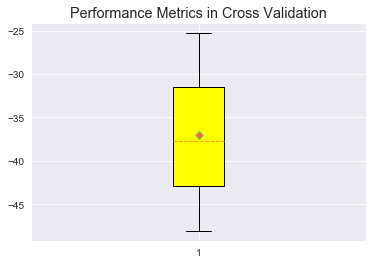



Model performance on train dataset
{'RMSE': 4.17, 'MAE': 2.54, 'R-squared': 0.96, 'MAPE': 6.52, 'Accuracy': 93.48}


Model performance on test dataset
{'RMSE': 5.68, 'MAE': 3.22, 'R-squared': 0.94, 'MAPE': 7.47, 'Accuracy': 92.53}


Trained models are saved on DISK... ... Done ...


In [36]:
RF_Regressor_GridSearch1(train_X, test_X, train_Y, test_Y, KFold = 3)

#### Load the pricing model 

In [37]:
file = open('Pricing_Model_RF_GridSearch1.pkl', 'rb')
pricing_model1 = pk.load(file)
file.close()

In [39]:
pricing_model1

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=6,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=201976,
                      verbose=0, warm_start=False)

#### Feature Importance - Random Forest Model 

In [40]:
feature_importance = pd.DataFrame({'features': list(train_X.columns),
                                  'importance': pricing_model1.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending = False).reset_index(drop = True)
feature_importance

,features,importance
0,tmv,0.253461
1,average_list_price_past28days,0.251519
2,most_recent_booked_price,0.234726
3,most_recent_nobooked_price,0.201504
4,probability_booked,0.025757
5,demand_supply_ratio,0.016731
6,booked_rate_past28days,0.010199
7,day_of_month,0.006103


#### Feature Importance - Permutation Importance

In [41]:
perm = PermutationImportance(pricing_model1, random_state = random_seed).fit(test_X, test_Y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

Weight,Feature
0.2452 ± 0.0325,tmv
0.1570 ± 0.0180,most_recent_booked_price
0.1450 ± 0.0213,average_list_price_past28days
0.0941 ± 0.0081,most_recent_nobooked_price
0.0081 ± 0.0027,probability_booked
0.0056 ± 0.0021,demand_supply_ratio
0.0023 ± 0.0016,booked_rate_past28days
0.0008 ± 0.0024,day_of_month


## Model Selection Conclusion
* Choose the Pricing_Model_RF_GridSearch1.pkl as final pricing recommendation model to recommend the price of vehicle

* The model variables (8 variables) in the final variables (order by the importance) are:
    * tmv
    * average_list_price_past28days
    * most_recent_booked_price
    * most_recent_nobooked_price
    * probability_booked
    * demand_supply_ratio
    * booked_rate_past28days
    * day_of_month	

## Mode Performance Summary
| Metrics                                 | Model Train Dataset | Model Test Dataset |
|-----------------------------------------|---------------------|--------------------|
| RMSE                                    | 4.17                | 5.68               |
| MAE                                     | 2.54                | 3.22               |
| R-squared                               | 0.96                | 0.94               |
| MAPE                                    | 6.52                | 7.47               |
| Accuracy                                | 93.48               | 92.53              |

### Univarate Analysis for each feature

In [42]:
def barchart_price(data, feat, target, n = 10):
    df = data.copy()
    if df[feat].nunique() < 10:
        vis = df.groupby([feat])[target].agg(['count', 'mean', 'median']).reset_index().rename(columns = {'count': 'Number of Observations', 'mean':'Average of Price($)', 'median': 'Median of Price($)'})
        vis['Percentage of Obsverations'] = round((vis['Number of Observations'] / vis['Number of Observations'].sum()) * 100, 2)
        vis['Average of Price($)'] = round(vis['Average of Price($)'], 2)
        vis['Median of Price($)'] = round(vis['Median of Price($)'], 2)  
        vis.rename(columns = {feat: 'decile'}, inplace = True)
    else:
        rank, bins = pd.qcut(df[feat], q = n, retbins = True, duplicates = 'drop')
        decile, ind = pd.factorize(rank, sort = True)
        df['decile'] = decile
        ind2 = pd.DataFrame({'decile': np.arange(0, len(ind)), feat + '_range':ind}) 
        df = df.merge(ind2, on = 'decile')
        df['decile'] = df['decile'] + 1 
        vis = df.groupby(['decile', feat + '_range'])[target].agg(['count', 'mean', 'median']).reset_index().rename(columns = {'count': 'Number of Observations', 'mean':'Average of Price($)', 'median': 'Median of Price($)'})                                                                        
        vis['Percentage of Obsverations'] = round((vis['Number of Observations'] / vis['Number of Observations'].sum()) * 100, 2)
        vis['Average of Price($)'] = round(vis['Average of Price($)'], 2)
        vis['Median of Price($)'] = round(vis['Median of Price($)'], 2)     
    print('Relation Between ' + feat + ' with ' + target + ' Summary Table')
    print(vis)
    print("\n========================================================")
    print('Relation Between ' + feat + ' with ' + target + ' Summary Chart')
    ax = sns.barplot(x='decile', y='Number of Observations', data=vis, color="Pink")
    vis['Average of Price($)'].plot(kind='line', color = 'k', secondary_y=True)
    vis['Median of Price($)'].plot(kind='line', color = 'r', secondary_y=True)
    plt.ylabel('Price($)')
    plt.ylim((20, 100))
    plt.legend(bbox_to_anchor=(1.10,1), loc="upper left")
    sns.despine(left=True)

Relation Between tmv with price Summary Table
    decile           tmv_range  Number of Observations  Average of Price($)  \
0        1  (3874.999, 5148.0]                     127                33.66   
1        2    (5148.0, 5669.0]                      77                31.43   
2        3    (5669.0, 5724.0]                     108                25.33   
3        4    (5724.0, 6353.0]                     123                32.26   
4        5    (6353.0, 7115.0]                      86                34.71   
5        6    (7115.0, 7484.0]                     112                41.59   
6        7    (7484.0, 8275.0]                     111                27.27   
7        8    (8275.0, 8941.0]                     103                39.98   
8        9    (8941.0, 9666.0]                      53                50.87   
9       10   (9666.0, 10850.0]                      58                32.10   
10      11  (10850.0, 12762.0]                     139                45.86   
11    

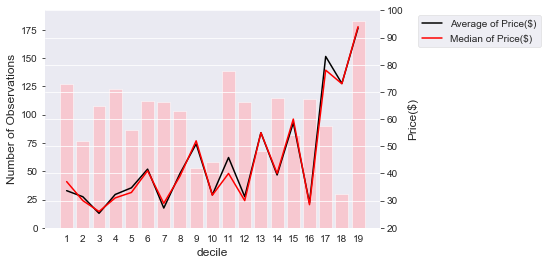

In [43]:
barchart_price(dataframe1, 'tmv', 'price', n = 20)

* tmv overall has a position relationship with price
* higher tmv can have higher price

Relation Between average_list_price_past28days with price Summary Table
    decile average_list_price_past28days_range  Number of Observations  \
0        1                      (-0.001, 24.0]                      96   
1        2                      (24.0, 25.663]                      93   
2        3                      (25.663, 27.0]                     117   
3        4                        (27.0, 29.0]                     109   
4        5                        (29.0, 30.0]                      72   
5        6                        (30.0, 31.6]                      81   
6        7                        (31.6, 33.0]                     117   
7        8                        (33.0, 34.0]                      82   
8        9                      (34.0, 37.291]                      84   
9       10                      (37.291, 39.0]                     144   
10      11                        (39.0, 40.0]                     184   
11      12                        (40.0,

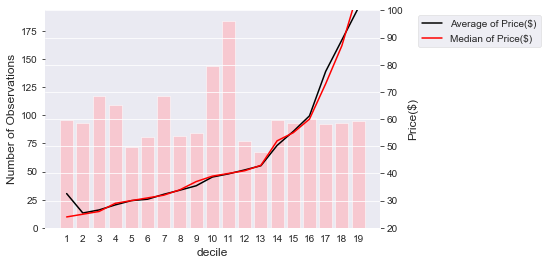

In [44]:
barchart_price(dataframe1, 'average_list_price_past28days', 'price', n = 20)

* average_list_price_past28days has a position relationship with price
* higher average_list_price_past28days will have higher price

Relation Between most_recent_booked_price with price Summary Table
    decile most_recent_booked_price_range  Number of Observations  \
0        1                 (-0.001, 20.0]                     192   
1        2                   (20.0, 24.0]                     152   
2        3                   (24.0, 25.0]                     101   
3        4                   (25.0, 26.0]                      67   
4        5                   (26.0, 29.0]                     113   
5        6                   (29.0, 30.0]                      88   
6        7                   (30.0, 31.0]                      67   
7        8                   (31.0, 33.0]                      87   
8        9                   (33.0, 36.0]                      83   
9       10                   (36.0, 39.0]                     215   
10      11                   (39.0, 40.0]                     167   
11      12                  (40.0, 42.75]                      85   
12      13                  (42.75, 

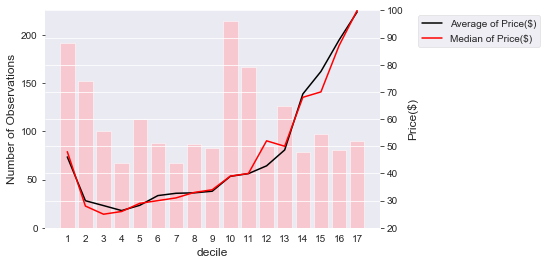

In [45]:
barchart_price(dataframe1, 'most_recent_booked_price', 'price', n = 20)

* most_recent_booked_price has a position relationship with price
* higher most_recent_booked_price will have higher price

Relation Between most_recent_nobooked_price with price Summary Table
    decile most_recent_nobooked_price_range  Number of Observations  \
0        1                   (-0.001, 24.0]                     353   
1        2                     (24.0, 25.0]                      35   
2        3                     (25.0, 27.0]                      86   
3        4                     (27.0, 30.0]                     157   
4        5                     (30.0, 32.0]                      44   
5        6                     (32.0, 34.6]                      81   
6        7                     (34.6, 36.0]                     113   
7        8                     (36.0, 38.0]                     135   
8        9                     (38.0, 39.0]                      55   
9       10                     (39.0, 40.0]                     164   
10      11                     (40.0, 41.0]                      73   
11      12                     (41.0, 45.0]                      38   
12      

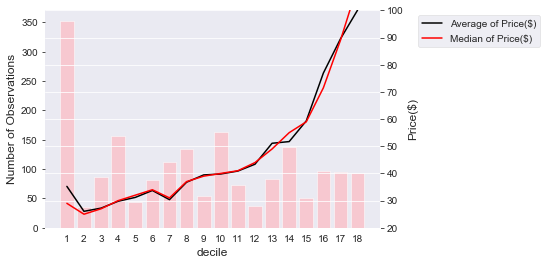

In [46]:
barchart_price(dataframe1, 'most_recent_nobooked_price', 'price', n = 20)

* most_recent_nobooked_price has a position relationship with price
* higher most_recent_nobooked_price will have higher price

Relation Between probability_booked with price Summary Table
    decile         probability_booked_range  Number of Observations  \
0        1  (0.0012100000000000001, 0.0109]                     100   
1        2                 (0.0109, 0.0208]                      90   
2        3                 (0.0208, 0.0385]                      94   
3        4                 (0.0385, 0.0852]                      99   
4        5                  (0.0852, 0.172]                      90   
5        6                    (0.172, 0.29]                      94   
6        7                    (0.29, 0.383]                      95   
7        8                   (0.383, 0.472]                      94   
8        9                   (0.472, 0.552]                      95   
9       10                   (0.552, 0.612]                      94   
10      11                   (0.612, 0.667]                      94   
11      12                   (0.667, 0.712]                      95   
12      13      

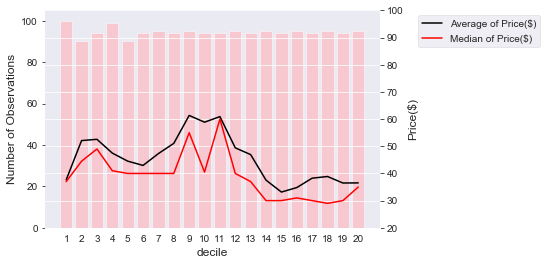

In [47]:
barchart_price(dataframe1, 'probability_booked', 'price', n = 20)

* probability_booked has a mixutal relationship with price 
* But when probability_booked is higher, the price is lower than price of lower probability_booked - as expected

Relation Between demand_supply_ratio with price Summary Table
    decile demand_supply_ratio_range  Number of Observations  \
0        1            (0.462, 0.824]                      95   
1        2            (0.824, 0.985]                      96   
2        3            (0.985, 1.221]                      93   
3        4            (1.221, 1.515]                      94   
4        5            (1.515, 3.003]                      95   
5        6            (3.003, 4.013]                      94   
6        7            (4.013, 4.613]                      95   
7        8            (4.613, 5.024]                      94   
8        9            (5.024, 5.343]                      95   
9       10            (5.343, 5.694]                      94   
10      11            (5.694, 6.186]                      94   
11      12            (6.186, 6.688]                      95   
12      13            (6.688, 7.259]                      94   
13      14            (7.259, 7.876]      

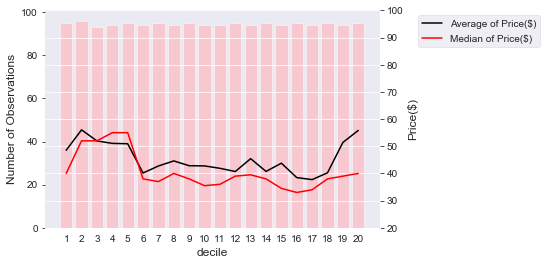

In [48]:
barchart_price(dataframe1, 'demand_supply_ratio', 'price', n = 20)

* demand_supply_ratio has a flat relationship with price 

Relation Between booked_rate_past28days with price Summary Table
    decile booked_rate_past28days_range  Number of Observations  \
0        1              (-0.001, 0.167]                     574   
1        2               (0.167, 0.333]                     117   
2        3               (0.333, 0.429]                      72   
3        4                 (0.429, 0.5]                      94   
4        5                   (0.5, 0.6]                      93   
5        6                 (0.6, 0.667]                     107   
6        7                (0.667, 0.75]                      99   
7        8                  (0.75, 0.8]                      89   
8        9                 (0.8, 0.857]                     104   
9       10                 (0.857, 0.9]                      73   
10      11                   (0.9, 1.0]                     468   

    Average of Price($)  Median of Price($)  Percentage of Obsverations  
0                 47.00                41.0             

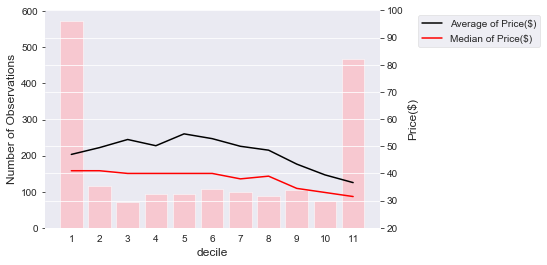

In [49]:
barchart_price(dataframe1, 'booked_rate_past28days', 'price', n = 20)

* booked_rate_past28days has a flat relationship with price 

Relation Between day_of_month with price Summary Table
    decile day_of_month_range  Number of Observations  Average of Price($)  \
0        1       (0.999, 2.0]                     124                44.59   
1        2         (2.0, 4.0]                     102                43.31   
2        3         (4.0, 5.0]                      72                44.85   
3        4         (5.0, 7.0]                     131                48.34   
4        5         (7.0, 8.0]                      59                43.51   
5        6        (8.0, 10.0]                     124                45.56   
6        7       (10.0, 11.0]                      54                43.78   
7        8       (11.0, 13.0]                     132                44.63   
8        9       (13.0, 14.0]                      64                46.08   
9       10       (14.0, 16.0]                     122                47.74   
10      11       (16.0, 17.0]                      67                43.04   
11      1

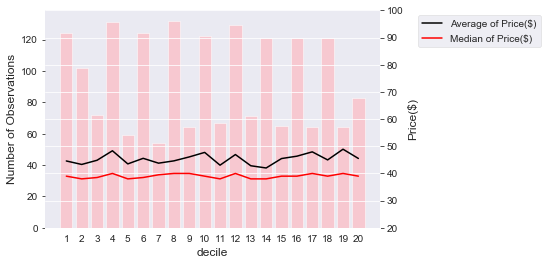

In [50]:
barchart_price(dataframe1, 'day_of_month', 'price', n = 20)

* day_of_month has a flat relationship with price 

## Next Step

### Score the whole dataframe1 dataset, add a column 'price_suggest in dataframe1 dataset using Pricing_Model_RF_GridSearch1.pkl

In [53]:
final_feature_list_price = [     'tmv',
    'average_list_price_past28days',
    'most_recent_booked_price',
    'most_recent_nobooked_price',
    'probability_booked',
    'demand_supply_ratio',
    'booked_rate_past28days',
    'day_of_month']

In [58]:
dataframe1['price_suggest'] = pricing_model1.predict(dataframe1[final_feature_list_price])

In [59]:
dataframe1

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,year_month,day_of_month,day_of_week,weekend,holiday,...,most_recent_booked_price,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select,probability_booked,price,price_suggest
758,508104,2018-10-21,5148,suv,8.616425,2018-10,21,7,1,0,...,39.0,44.0,21.0,0.200000,43.000000,0,Development,0.174835,44,41.313534
101,326416,2018-12-10,12762,suv,3.059283,2018-12,10,1,0,0,...,40.0,40.0,27.0,0.071429,40.000000,0,Development,0.089107,40,41.052848
270,298081,2019-01-07,5724,midsize,7.097282,2019-01,7,1,0,0,...,26.0,26.0,5.0,0.875000,25.750000,1,Development,0.871653,26,27.926231
110,174075,2018-05-01,5669,midsize,4.617152,2018-05,1,2,0,0,...,30.0,30.0,8.0,0.666667,30.000000,1,Development,0.685656,34,31.560738
353,426430,2019-01-29,7115,midsize,3.574344,2019-01,29,2,0,0,...,46.0,46.0,11.0,0.666667,41.000000,0,Development,0.356414,46,46.402135
716,388325,2018-10-23,8941,compact,4.974412,2018-10,23,2,0,0,...,39.0,41.0,56.0,0.000000,41.000000,0,Development,0.019581,41,41.998638
1793,300476,2019-02-22,6353,suv,6.610945,2019-02,22,5,0,0,...,31.0,29.0,45.0,0.000000,32.000000,0,Development,0.104561,31,31.039865
660,302205,2018-09-13,19525,compact,5.563430,2018-09,13,4,0,0,...,28.0,35.0,1.0,0.727273,30.000000,1,Development,0.884931,32,32.936659
1575,233590,2018-08-29,7484,suv,8.331370,2018-08,29,3,0,0,...,32.0,51.0,1.0,1.000000,33.000000,1,Development,0.871730,32,37.862154
906,233590,2018-04-24,7484,suv,5.419304,2018-04,24,2,0,0,...,0.0,49.0,0.0,0.000000,47.800000,0,Development,0.032199,48,45.214000


In [60]:
dataframe1.to_csv('dataframe_price_suggest_final_result.csv', index=False)

## Measuring business impact

* There are 5 different metrics can measure the model output (suggested price) impact on business
    * Price Decrease Recall (PDR): among all non-booked date, the percentage of predict / suggest price that are lower than ground truth / list price
    * Price Decrease Precision (PDP): among all cases where Psug < P (suggest price < list price), the percentage of days that are non-booked
    * Price Increase Recall (PIR): among all booked days, the percentage of suggest price that are higher than or equal to list prices
    * Price Increase Precision (PIP): among all cases where Psug >= P (suggest price >= list price), the percentage of days that are booked
    * Booking Regret (BR): $$BR = average_{bookings}(max(0, (P - P_{suggest}) / P)$$

### All following metrics calculation is based on the 30% test dataset from pricing recommendation model building

#### Price Decrease Recall (PDR)
* Among all non-booked date, the percentage of predict / suggest price that are lower than ground truth / list price

In [68]:
def price_decrease_recall(data):
    df = data.copy()
    df_nonbooked = df.loc[df['is_booked'] == 0, :]
    df_nonbooked ['price_diff'] = df_nonbooked['price'] - df_nonbooked['price_suggest']
    df_nonbooked ['indicator'] = df_nonbooked ['price_diff'].apply(lambda x: 1 if x > 0 else 0)
    pdr = round(100 * df_nonbooked ['indicator'].sum() / len(df_nonbooked ['indicator']), 2)
    return pdr

In [113]:
price_decrease_recall(dataframe1.loc[dataframe1['select'] == 'Development'])

44.88

In [69]:
price_decrease_recall(dataframe1.loc[dataframe1['select'] == 'Test'])

43.28

#### Price Decrease Precision (PDP)
* among all cases where Psug < P (suggest price < list price), the percentage of days and vehicle that are non-booked

In [130]:
def price_decrease_precision(data):
    df = data.copy()
    df['price_diff'] = df['price'] - df['price_suggest']
    df_small = df.loc[df['price_diff'] > 0, :]
    pdp = 100 - round(100 * df_small['is_booked'].sum() / len(df_small['is_booked']), 2)
    return pdp

In [131]:
price_decrease_precision(dataframe1.loc[dataframe1['select'] == 'Development'])

47.89

In [132]:
price_decrease_precision(dataframe1.loc[dataframe1['select'] == 'Test'])

51.79

#### Price Increase Recall (PIR)
* among all booked days, the percentage of suggest price that are higher than or equal to list prices

In [87]:
def price_increase_recall(data):
    df = data.copy()
    df_booked = df.loc[df['is_booked'] == 1, :]
    df_booked ['price_diff'] = df_booked['price'] - df_booked['price_suggest']
    df_booked ['indicator'] = df_booked ['price_diff'].apply(lambda x: 1 if x <= 0 else 0)
    pir = round(100 * df_booked ['indicator'].sum() / len(df_booked ['indicator']), 2)
    return pir

In [110]:
price_increase_recall(dataframe1.loc[dataframe1['select'] == 'Development'])

58.72

In [88]:
price_increase_recall(dataframe1.loc[dataframe1['select'] == 'Test'])

63.88

#### Price Increase Precision (PIP)
* among all cases where Psug >= P (suggest price >= list price), the percentage of days that are booked

In [89]:
def price_increase_precision(data):
    df = data.copy()
    df['price_diff'] = df['price'] - df['price_suggest']
    df_big = df.loc[df['price_diff'] <= 0, :]
    pip = round(100 * df_big['is_booked'].sum() / len(df_big['is_booked']), 2)
    return pip

In [111]:
price_increase_precision(dataframe1.loc[dataframe1['select'] == 'Development'])

55.76

In [90]:
price_increase_precision(dataframe1.loc[dataframe1['select'] == 'Test'])

55.69

#### Booking Regret (BR)
* $$BR = average_{bookings}(max(0, (P - P_{suggest}) / P)$$

In [114]:
def booking_regret(data):
    df = data.copy()
    df_booked = df.loc[df['is_booked'] == 1, :]
    df_booked['price_diff_ratio'] = round((100 * (df_booked['price'] - df_booked['price_suggest']) / df_booked['price']), 2)
    df_booked['price_diff_ratio'] = df_booked ['price_diff_ratio'].apply(lambda x: 0 if x < 0 else x)
    br = round(df_booked['price_diff_ratio'].mean(), 2)
    return br

In [115]:
booking_regret(dataframe1.loc[dataframe1['select'] == 'Development'])

3.71

In [116]:
booking_regret(dataframe1.loc[dataframe1['select'] == 'Test'])

3.47

In [117]:
dataframe1.head()

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,year_month,day_of_month,day_of_week,weekend,holiday,...,most_recent_booked_price,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select,probability_booked,price,price_suggest
758,508104,2018-10-21,5148,suv,8.616425,2018-10,21,7,1,0,...,39.0,44.0,21.0,0.200000,43.00,0,Development,0.174835,44,41.313534
101,326416,2018-12-10,12762,suv,3.059283,2018-12,10,1,0,0,...,40.0,40.0,27.0,0.071429,40.00,0,Development,0.089107,40,41.052848
270,298081,2019-01-07,5724,midsize,7.097282,2019-01,7,1,0,0,...,26.0,26.0,5.0,0.875000,25.75,1,Development,0.871653,26,27.926231
110,174075,2018-05-01,5669,midsize,4.617152,2018-05,1,2,0,0,...,30.0,30.0,8.0,0.666667,30.00,1,Development,0.685656,34,31.560738
353,426430,2019-01-29,7115,midsize,3.574344,2019-01,29,2,0,0,...,46.0,46.0,11.0,0.666667,41.00,0,Development,0.356414,46,46.402135


In [118]:
dataframe1['diff'] = dataframe1['price'] - dataframe1['price_suggest']

In [120]:
dataframe1['indicator'] = dataframe1['diff'].apply(lambda x: 1 if x <= 0 else 0)

In [121]:
dataframe1.head()

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,year_month,day_of_month,day_of_week,weekend,holiday,...,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select,probability_booked,price,price_suggest,diff,indicator
758,508104,2018-10-21,5148,suv,8.616425,2018-10,21,7,1,0,...,21.0,0.200000,43.00,0,Development,0.174835,44,41.313534,2.686466,0
101,326416,2018-12-10,12762,suv,3.059283,2018-12,10,1,0,0,...,27.0,0.071429,40.00,0,Development,0.089107,40,41.052848,-1.052848,1
270,298081,2019-01-07,5724,midsize,7.097282,2019-01,7,1,0,0,...,5.0,0.875000,25.75,1,Development,0.871653,26,27.926231,-1.926231,1
110,174075,2018-05-01,5669,midsize,4.617152,2018-05,1,2,0,0,...,8.0,0.666667,30.00,1,Development,0.685656,34,31.560738,2.439262,0
353,426430,2019-01-29,7115,midsize,3.574344,2019-01,29,2,0,0,...,11.0,0.666667,41.00,0,Development,0.356414,46,46.402135,-0.402135,1


In [123]:
dataframe1.loc[dataframe1['select'] == 'Test', :].groupby(['indicator', 'is_booked']).size()

indicator  is_booked
0          0            116
           1            108
1          0            152
           1            191
dtype: int64

##### Cross matrix of is_booked and (Psuggest vs. P) based on 30% Test Dataset

| Psuggest Vs. P                          | Booked              | Not Booked         |
|-----------------------------------------|---------------------|--------------------|
| Psuggest >= P                           | a (191)             | b (152)            |
| Psuggest < P                            | c (108)             | d (116)            |

### The following metrics were calculated on 30% Test Dataset
#### 1. Booking Regret 
* BR_test = $BR = average_{bookings}(max(0, (P - P_{suggest}) / P)$ = 3.47%

#### 2. Price Decrease Recall (PDR) 
* PDR_test = d / (b + d) = 116 / (116 + 152) = 43.28%

#### 3. Price Decrease Precision (PDP) 
* PDP_test = d / (c + d) = 116 / (116 + 108) = 51.79%

#### 4. Price Increase Recall (PIR)
* PIR_test = a / (a + c) = 191 / (191 + 108) = 63.88%

#### 5. Price Increase Precision (PIP)
* PIP_test = a / (a + b) = 191 / (191 + 152) = 55.69%

### Summary
| Metrics                                 | Model Train Dataset | Model Test Dataset |
|-----------------------------------------|---------------------|--------------------|
| Price Decrease Recall (PDR)             | 44.88%              | 43.28%             |
| Price Decrease Precision (PDP)          | 47.89%              | 51.79%             |
| Price Increase Recall (PIR)             | 58.72%              | 63.88%             |
| Price Increase Precision (PIP)          | 55.76%              | 55.69%             |
| Booking Regret (BR)                     | 3.71%               | 3.47%              |